# Conditional GANs

## Evaluating the quality of generated class-specific data


From:

L. Akritidis, A. Fevgas, M. Alamaniotis, P. Bozanis, "Conditional Data Synthesis with Deep Generative Models for Imbalanced Dataset Oversampling", In Proceedings of the 35th IEEE International Conference on Tools with Artificial Intelligence (ICTAI), to appear, 2023.

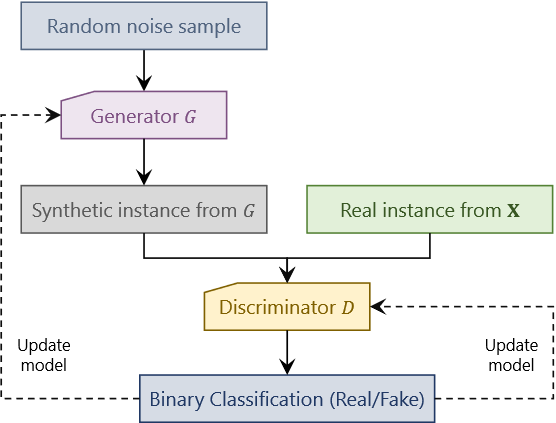


Generative Adversarial Nets (GANs) are among the leading architectures in the area of generative modeling. Inside a GAN, two Neural Networks compete each other with the aim of learning the target distribution and generating artificial
data: a Discriminator $D$ and a Generator $G$.

The Discriminator $D$ is a binary classifier trained to distinguish whether its input data samples are real or not. For this reason, $D$ trained with both real and fake examples. The real examples are drawn from the original training set $\mathbf{X}$, whereas the fake ones are synthesized by the Generator $G$. Its loss function penalizes all misclassifications, namely, real data identified as fake, or fake data identified as real. At each iteration, $D$ updates its parameters using backpropagation, thus improving its ability to identify fake data instances.

The Generator $G$ learns to synthesize artificial data instances by using the output of $D$. Its goal is to deceive the discriminator $D$, so that its output is classified as real. The training of $G$ takes place simultaneously with that of $D$ and involves the following phases: Initially, a random noise sample is used it to produce the output of $G$. The output of $G$ is fed to $D$ and the discriminator loss is computed. The error is then backpropagated to compute the necessary gradients and update only the weights of $G$.

Formally, $D$ and $G$ play the following zero-sum game:

$$\min_G\max_D V(D,G)=\mathbb{E}_{\mathbf{x}\sim p_{\mathbf{x}}(\mathbf{x})}[\log(D(\mathbf{x}))]+
\mathbb{E}_{\mathbf{z}\sim p_{z}(\mathbf{z})}[\log(1-D(G(\mathbf{z})))]$$


In many cases, the objective is not to simply generate artificial data, but to synthesize data instances belonging to a particular class. Conditional GANs (CGANs) address this requirement by receiving as inputs both the samples and their respective classes $\mathbf{y}$ \cite{arxiv2014}. This applies to both Discriminator and Generator, so the aforementioned zero-sum game becomes: 

$$\min_G\max_D V(D,G)=\mathbb{E}_{\mathbf{x}\sim p_{\mathbf{x}}(\mathbf{x}|)}[\log(D(\mathbf{x}|\mathbf{y}))]+
\mathbb{E}_{\mathbf{z}\sim p_{z}(\mathbf{z})}[\log(1-D(G(\mathbf{z}|\mathbf{y})))]$$

During CGAN training, the one-hot-encoded vectors $\mathbf{y}$ are fed to both the Discriminator and the Generator, after they have been concatenated with the input feature vectors (either fake, or real ones).


In [1]:
import os

import matplotlib.pyplot as plt

from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# DeepCore ML imports
import DataTools
from Datasets import BaseDataset
from DataSamplers import DataSamplers
from Classifiers import Classifiers
from DataTransformers import FeatureTransformer
from ResultHandler import ResultHandler

from Datasets import BaseDataset
from GANs.CGAN import cGAN

seed=1
DataTools.set_random_states(1)


## Data

The following code produces a random dataset of `num_samples` samples classified into `num_classes` classes. The dataset is intentinally imbalanced; each class comprises different numbers of samples. The imbalance ratio is controlled by the `class_weights` array.


Num Samples: 1000 
Class Distribution:
	Class 0 : 500 samples
	Class 1 : 300 samples
	Class 2 : 100 samples
	Class 3 : 100 samples


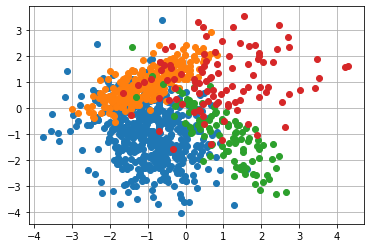

In [2]:
class_weights = [0.50, 0.30, 0.1, 0.1 ]

synthetic_dataset = BaseDataset(random_state=seed)
synthetic_dataset.create_synthetic(n_samples=1000, n_classes=len(class_weights), imb_ratio=class_weights)

num_classes = synthetic_dataset.num_classes_
x_data = synthetic_dataset.x_
y_data = synthetic_dataset.y_

min_x = x_data[:,0].min()
max_x = x_data[:,0].max()
min_y = x_data[:,1].min()
max_y = x_data[:,1].max()

fig = plt.figure(figsize=(6, 4))

ax=fig.add_subplot(111)
ax.clear()
ax.grid(True)
ax.set_xlim(1.1 * min_x, 1.1 * max_x)
ax.set_ylim(1.1 * min_y, 1.1 * max_y)

for c in range(num_classes):
    hcor = [x[0] for n, x in enumerate(x_data) if y_data[n] == c]
    vcor = [x[1] for n, x in enumerate(x_data) if y_data[n] == c]
    ax.plot(hcor, vcor, 'o')

plt.show()


## Discriminator

A typical GAN discriminator is a binary classifier that produces 0/1 (real/fake) outputs. Thus, there is only a
single neuron in the output layer and its activation function is the Logistic Sigmoid function.

The Discriminator is implemented as a typical feed-forward  fully-connected network. Its architecture and the
dimensionality of the input data are passed as parameters to the constructor of the class.

The Leaky Rectified Linear Unit (LeakyReLU) is the activation function of all neurons in each layer.
Each layer of the network is followed by a Dropout layer to prevent the model from over-fitting.


## Generator

The Generator is a fully connected network comprised of a stack of residual blocks. Its architecture and the dimensionality of the input data are passed as parameters to the constructor. The dimensionality of the input is the dimensionality of the latent (noise) samples. Its output dimensionality is the dimensionality of the data that we want to generate (typically, equal to the dimensionality of the training data -> discriminator input).

The Leaky Rectified Linear Unit (Leaky ReLU) is the activation function of all neurons in each layer. Dropout is not applied here to prevent the model from over-fitting. Batch normalization has a destructive impact on the performance of Generator.


## Conditional GAN (cGAN)

Conditional GANs (cGANs) can conditionally generate data for a given class. In a typical setting, a user requests from a cGAN to generate samples belonging to a particular class and the network outputs samples matching the request.

cGANs are trained by providing not only the sample vectors, but also the class labels. In a typical implementation, the class labels are initially one-hot-encoded; then, the one-hot-encoded class representation is concatenated with the feature vectors and fed to both the Discriminator and the Generator.


## cGAN architecture & Training params

In [3]:
disc = (128, 64, 32)
gen = (64, 64)

NUM_EPOCHS = 300
BATCH_SIZE = 32


## cGAN Training

In [4]:
c_gan = cGAN(discriminator=disc, generator=gen, pac=1, random_state=seed)

# c_gan.train(x_data, y_data, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, loss_function=nn.BCELoss())

c_gan.train(x_data, y_data, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)


(tensor(0.0970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(1.9374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>))

In [5]:
synthetic_data = [[]] * num_classes

for c in range(num_classes):
    synthetic_data[c] = c_gan.sample(200, c).cpu().detach()


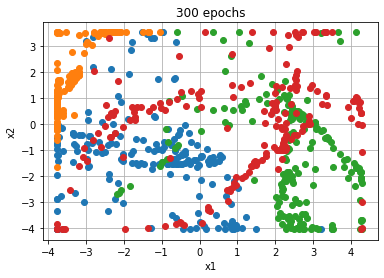

In [6]:
fig_final = plt.figure()

ax_final = fig_final.add_subplot(111)
ax_final.clear()
ax_final.grid(True)
ax_final.set_xlim(1.1 * min_x, 1.1 * max_x)
ax_final.set_ylim(1.1 * min_y, 1.1 * max_y)
ax_final.set_title(str(NUM_EPOCHS) + " epochs")
ax_final.set_xlabel("x1")
ax_final.set_ylabel("x2")

for c in range(num_classes):
    ax_final.plot(synthetic_data[c][:, 0], synthetic_data[c][:, 1], 'o')

plt.show()


In [11]:
c_gan_bal = cGAN(discriminator=disc, generator=gen, pac=1, random_state=seed)
balanced_x, balanced_y = c_gan_bal.fit_resample(x_data, y_data)


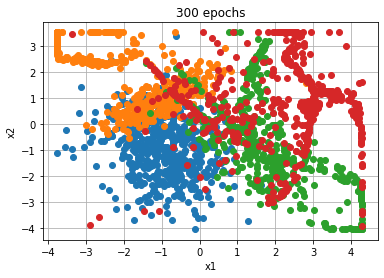

In [20]:
import numpy as np
balanced_data = np.array([ [balanced_x[k] for k in range(balanced_x.shape[0]) if balanced_y[k] == c ] for c in range(num_classes) ])

fig_final = plt.figure()

ax_final = fig_final.add_subplot(111)
ax_final.clear()
ax_final.grid(True)
ax_final.set_xlim(1.1 * min_x, 1.1 * max_x)
ax_final.set_ylim(1.1 * min_y, 1.1 * max_y)
ax_final.set_title(str(NUM_EPOCHS) + " epochs")
ax_final.set_xlabel("x1")
ax_final.set_ylabel("x2")

for c in range(num_classes):
    ax_final.plot(balanced_data[c][:, 0], balanced_data[c][:, 1], 'o')

plt.show()